In [6]:
29e3/12e6

0.002416666666666667

# A win state is such that the infection has ended and a losing state is such that the number of patients is higher than the number of beds

# We can only restrict work and school relations. Home raltions can never be modified.

## Code copied from "spread dependent on region status"

# Acording to data from 2018, the city of Sao Paulo has approximately 5000 UTI (ICU) beds. 
https://portal.cfm.org.br/images/PDF/leitosdeuticapitais2018.pdf

# We are going however to not distinguish between patients hospitalized that need ICU and those that do not. So we are going to use the number of 2018 of 29 000 total hospital beds in the city of Sao Paulo. 

http://tabnet.datasus.gov.br/cgi/tabcgi.exe?cnes/cnv/leiintsp.def
https://www.redesocialdecidades.org.br/br/SP/sao-paulo/leitos-hospitalares

# That gives us a ratio of approximately 0.0025 hospital beds per person.

# If the ratio of people hospitalized in the city gets over that, than the policy has failed

# We will try and see if by locking down all schools and work we can always stay below that threshold

In [1]:
import os
os.chdir('../..')

from src.models import patient_evolution

In [46]:
import numpy as np
import networkx as nx
import pandas as pd
import collections
from tqdm import tqdm

# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman',
               pop_size = 1000, seed = None):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 5, 0.4, seed)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size, seed=seed)
    elif graph_model == 'SP':
        G = nx.read_gpickle('src/models/Grafo_Zonas_SP.gpickle')
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model, pop_size = 1000, seed=None):
    G = init_graph(initial_infection, graph_model, pop_size, seed)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """   
    for node in G.nodes():
        G.nodes[node].update({
                      'status': 'susceptible', 
                      'infection_day' : -1, 
                      'contacts_infected' : 0
        })

    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size, replace = False)
    
    for i in infected:
        patient_evolution.susceptible_to_exposed(G.nodes[i], 0)

def lambda_leak_value(infected_ratio, max_value=0.05, exp=3): 
    return (infected_ratio**exp)*max_value

def spread_one_step(G, day, infected_ratio, p_r = 0.5, lambda_leak_max = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
    
    lambda_leak = lambda_leak_value(infected_ratio, max_value = lambda_leak_max)
    for node, adjacencies in G.adjacency():
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies.keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    newly_infected = np.unique(newly_infected)
    
    patient_evolution.infect_graph(G, newly_infected, day)
    
    return newly_infected.size

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and removed
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

def current_status_by_zone(G):   
    result = collections.Counter(node['home'] for i,node in G.nodes(data=True) \
                                            if node['status']=='infected')

    people_per_zone = dict(collections.Counter(node['home'] for i,node in G.nodes(data=True)))
    
    for k,v in result.items():
        result[k] = v/people_per_zone[k]
        
    return dict(result)


def get_mean_contacts_infected(G):
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True)\
                                                             if node['status'] == 'removed']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
            
        return contacts_infected
    
def get_time_series_row(G, pop):
    status = current_status(G)
    s = status['susceptible'] / pop
    i = status['infected'] / pop
    r = status['removed'] / pop
    h = status['hospitalized'] / pop
    e = status['exposed'] / pop

    contacts_infected = get_mean_contacts_infected(G)
    
    return s, e, i, r, h, contacts_infected, status
    
def simulate_pandemic(work_r=0, school_r = 0, home_r=0, initial_infection=.05, recover_time=12, p_r=.5, lambda_leak=.05,
                      graph_model = 'relaxed_caveman', pop_size = 1000,
                      seed = None, it=None):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, pop_size, seed)
    
    data_per_region = []
    
    zones = range(1, 343)
    
    infected_per_relation = {
        'house': 0,
        'work' : 0,
        'school': 0
    }
    
    for day in tqdm(range(250)):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
    
        patient_evolution.update_graph(G)
        
        #This was not being used, was this expected?
        #newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        s, e, i, r, h, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, e, i, r, h, contacts_infected, status])
        
        
        if graph_model == 'SP':
            data_per_region.append(current_status_by_zone(G))
            spread_thorugh_regions(G=G, day=day, zones=zones, school_r=school_r, work_r=work_r, 
                                               p_r = p_r, lambda_leak_max=lambda_leak, 
                                                   home_r=home_r, infected_per_relation=infected_per_relation)
        
        else:
             _ = spread_one_step(G, day, status['infected'] / pop, p_r, lambda_leak)
        
    columns = ['susceptible', 'exposed', 'infected', 'removed', 'hospitalized', 'contacts_infected_mean', 'status']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series, G, data_per_region, infected_per_relation


In [54]:
def subgraph_of_zone(G, zone, relation):
    zone_nodes = [x for x,y in G.nodes(data=True) if y[relation]==zone]
    return G.subgraph(zone_nodes)

def subgraph_of_relation(G, relation):
    relation_edges = [(x,y) for x,y,values in G_1.edges(data=True) if values['edge_type']==relation]
    return G.edge_subgraph(relation_edges)

def percentage_infected(G):
    pop = len(G.nodes)
    if pop < 1: return 0
    
    infected = len([True for i,node in G.nodes(data=True) if node['status']=='infected'])
    
    return infected/pop

def leak_and_spread(G, day, p_r = 0.5, lambda_leak_max = 0.05, zone_restriction=0):
    
    newly_infected = 0
    
    infected_ratio = percentage_infected(G)
    
    if infected_ratio <= 0: return 0
    
    lambda_leak = lambda_leak_value(infected_ratio, max_value = lambda_leak_max)
    
    for node, adjacencies in G.adjacency():
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                patient_evolution.infect_node(G.nodes[node], day)
                newly_infected += 1
            else:
                for contact in adjacencies.keys():
                    if G.nodes[contact]['status'] == 'infected':
                        if np.random.random() < p_r and np.random.random() > zone_restriction:
                            patient_evolution.infect_node(G.nodes[node], day)
                            G.nodes[contact]['contacts_infected'] += 1
                            newly_infected += 1
                            break  
                            
    return newly_infected

"""
Deprecated
Useful if each region can have specific value for lockdown
def spread_thorugh_regions(G, day, zones, school_r, work_r, 
                                               p_r = 0.5, lambda_leak_max = 0.05,home_r=0, ):
    
    newly_infected = {
        'home' : 0,
        'work' : 0,
        'school' : 0, 
    }
    
    for restriction, relation in zip([home_r, work_r, school_r], ['home','work', 'school']):
        for z in zones:
            sub_Graph = subgraph_of_zone(G, z, relation)
            newly_infected[relation] += leak_and_spread(sub_Graph, day, p_r, lambda_leak_max, restriction)
    
    return newly_infected
"""


def spread_thorugh_regions(G, day, zones, school_r, work_r, infected_per_relation, 
                                               p_r = 0.5, lambda_leak_max = 0.05,home_r=0):
       
    for restriction, relation in zip([home_r, work_r, school_r], ['work', 'house', 'school']):
            sub_Graph = subgraph_of_relation(G, relation)
            infected_per_relation[relation] += leak_and_spread(sub_Graph, day, p_r, lambda_leak_max, restriction)
    

 44%|████▍     | 110/250 [03:46<04:47,  2.06s/it]


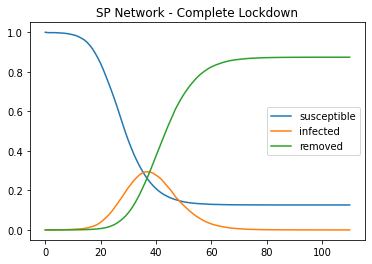

In [42]:
import matplotlib.pyplot as plt

time_series_1, G_1, data_per_region_1 = simulate_pandemic(work_r=0, school_r=0,
                                                             graph_model = 'SP', p_r = 0.3,
                                                             lambda_leak=0, pop_size=5000, 
                                                             initial_infection = 100/50000)





plt.plot(time_series_1.index, time_series_1['susceptible'], label = 'susceptible')
plt.plot(time_series_1.index, time_series_1['infected'], label = 'infected')
plt.plot(time_series_1.index, time_series_1['removed'], label = 'removed')
plt.legend()
plt.title('SP Network - Complete Lockdown')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

In [71]:
time_series_1.iloc[time_series_1.infected.idxmax()]

susceptible                                                         0.25665
exposed                                                            0.168979
infected                                                           0.294151
removed                                                            0.268958
hospitalized                                                      0.0112629
newly_infected                                                      2.04288
contacts_infected_mean    {'removed': 14925, 'infected': 16323, 'suscept...
Name: 37, dtype: object

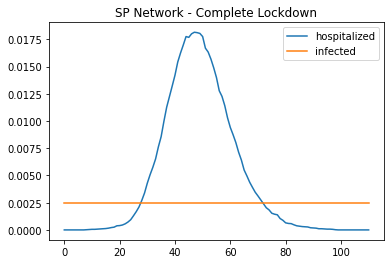

In [43]:
plt.plot(time_series_1.index, time_series_1['hospitalized'], label = 'hospitalized')
plt.plot(time_series_1.index, len(time_series_1.index)*[0.0025], label = 'infected')
plt.legend()
plt.title('SP Network - No Restrictions')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

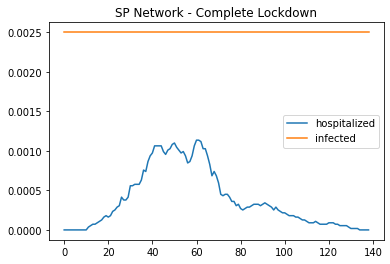

In [9]:
plt.plot(time_series_1.index, time_series_1['hospitalized'], label = 'hospitalized')
plt.plot(time_series_1.index, len(time_series_1.index)*[0.0025], label = 'infected')
plt.legend()
plt.title('SP Network - Complete Lockdown')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

 53%|█████▎    | 132/250 [14:40<13:07,  6.67s/it]


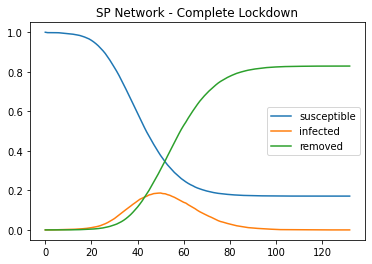

In [11]:
import matplotlib.pyplot as plt

time_series_2, G_2, data_per_region_2 = simulate_pandemic(work_r=.7, school_r=1,
                                                             graph_model = 'SP', p_r = 0.3,
                                                             lambda_leak=0, pop_size=50000, 
                                                             initial_infection = 100/50000)





plt.plot(time_series_2.index, time_series_2['susceptible'], label = 'susceptible')
plt.plot(time_series_2.index, time_series_2['infected'], label = 'infected')
plt.plot(time_series_2.index, time_series_2['removed'], label = 'removed')
plt.legend()
plt.title('SP Network - Complete Lockdown')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

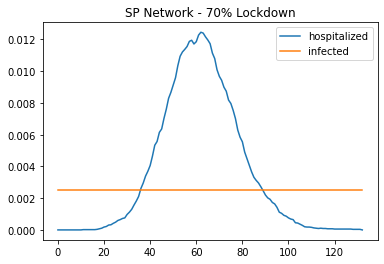

In [40]:
plt.plot(time_series_2.index, time_series_2['hospitalized'], label = 'hospitalized')
plt.plot(time_series_2.index, time_series_2['hospitalized'], label = 'hospitalized')

plt.plot(time_series_2.index, len(time_series_2.index)*[0.0025], label = 'infected')
plt.legend()
plt.title('SP Network - 70% Lockdown')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

 70%|███████   | 175/250 [06:23<02:44,  2.19s/it]


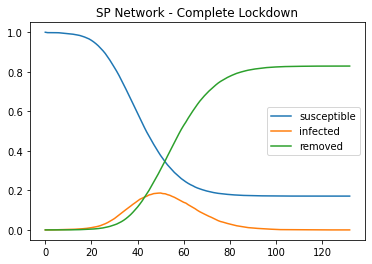

In [33]:
import matplotlib.pyplot as plt

time_series_3, G_3, data_per_region_3 = simulate_pandemic(work_r=.7, school_r=1,
                                                             graph_model = 'SP', p_r = 0.3,
                                                             lambda_leak=0, pop_size=50000, 
                                                             initial_infection = 100/50000)





plt.plot(time_series_2.index, time_series_2['susceptible'], label = 'susceptible')
plt.plot(time_series_2.index, time_series_2['infected'], label = 'infected')
plt.plot(time_series_2.index, time_series_2['removed'], label = 'removed')
plt.legend()
plt.title('SP Network - Complete Lockdown')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

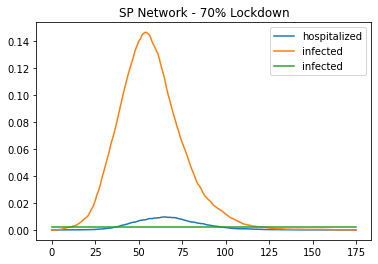

In [41]:
plt.plot(time_series_3.index, time_series_3['hospitalized'], label = 'hospitalized')
plt.plot(time_series_3.index, time_series_3['infected'], label = 'infected')
plt.plot(time_series_3.index, len(time_series_3.index)*[0.0025], label = 'infected')
plt.legend()
plt.title('SP Network - 70% Lockdown')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

 45%|████▌     | 113/250 [04:03<04:54,  2.15s/it]


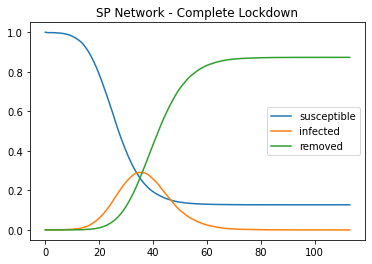

In [52]:
import matplotlib.pyplot as plt

time_series, G, data_per_region, infct_per_relation = simulate_pandemic(work_r=0, school_r=0,
                                                             graph_model = 'SP', p_r = 0.3,
                                                             lambda_leak=0, pop_size=5000, 
                                                             initial_infection = 100/50000,
                                                                       seed = 420)





plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['removed'], label = 'removed')
plt.legend()
plt.title('SP Network - Complete Lockdown')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

In [53]:
# Houses infect first
infct_per_relation

{'house': 21345, 'work': 17912, 'school': 9076}

 46%|████▌     | 114/250 [04:08<04:56,  2.18s/it]


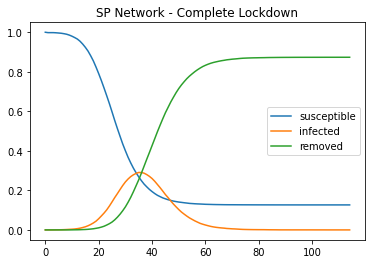

In [55]:
import matplotlib.pyplot as plt

time_series, G, data_per_region, infct_per_relation = simulate_pandemic(work_r=0, school_r=0,
                                                             graph_model = 'SP', p_r = 0.3,
                                                             lambda_leak=0, pop_size=5000, 
                                                             initial_infection = 100/50000,
                                                                       seed = 420)





plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['removed'], label = 'removed')
plt.legend()
plt.title('SP Network - Complete Lockdown')
#plt.savefig('SP network Simulation- no restrictions.png', fromat='png', dpi = 300)
plt.show()

In [56]:
# Work infecting first
infct_per_relation

{'house': 20675, 'work': 18714, 'school': 8972}

In [62]:
([node['work'] for i,node in G.nodes(data=True)])

[3.0,
 82.0,
 1.0,
 1.0,
 26.0,
 nan,
 2.0,
 2.0,
 nan,
 54.0,
 nan,
 53.0,
 79.0,
 nan,
 nan,
 nan,
 nan,
 239.0,
 nan,
 3.0,
 1.0,
 nan,
 nan,
 nan,
 153.0,
 nan,
 1.0,
 7.0,
 1.0,
 1.0,
 nan,
 4.0,
 4.0,
 112.0,
 4.0,
 1.0,
 nan,
 nan,
 43.0,
 144.0,
 29.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 27.0,
 66.0,
 nan,
 nan,
 339.0,
 67.0,
 nan,
 43.0,
 nan,
 nan,
 73.0,
 201.0,
 nan,
 nan,
 78.0,
 6.0,
 49.0,
 nan,
 31.0,
 4.0,
 nan,
 1.0,
 1.0,
 nan,
 1.0,
 1.0,
 19.0,
 300.0,
 2.0,
 2.0,
 nan,
 1.0,
 2.0,
 nan,
 nan,
 77.0,
 nan,
 3.0,
 nan,
 3.0,
 nan,
 1.0,
 1.0,
 nan,
 24.0,
 nan,
 nan,
 165.0,
 73.0,
 nan,
 nan,
 nan,
 270.0,
 nan,
 nan,
 131.0,
 250.0,
 nan,
 136.0,
 75.0,
 nan,
 nan,
 2.0,
 nan,
 nan,
 2.0,
 2.0,
 nan,
 nan,
 129.0,
 nan,
 35.0,
 2.0,
 2.0,
 nan,
 2.0,
 nan,
 nan,
 2.0,
 nan,
 nan,
 nan,
 nan,
 2.0,
 73.0,
 nan,
 65.0,
 2.0,
 2.0,
 2.0,
 2.0,
 81.0,
 nan,
 2.0,
 2.0,
 2.0,
 2.0,
 nan,
 7.0,
 2.0,
 nan,
 nan,
 nan,
 7.0,
 2.0,
 nan,
 nan,
 2.0,
 2.0,
 6.0,
 2.0,
 2

In [64]:
!pwd

/home/yamba/Desktop/CovidMDP
